# Time series analysis part 2

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, mean_absolute_error, median_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [76]:
ads = pd.read_csv('datasets/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('datasets/currency.csv', index_col=['Time'], parse_dates=['Time'])

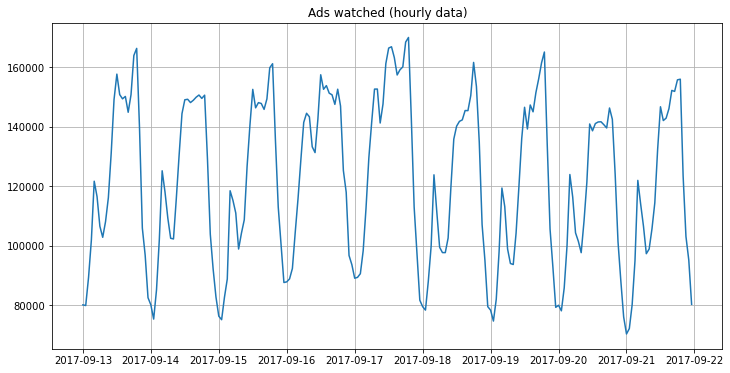

In [77]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

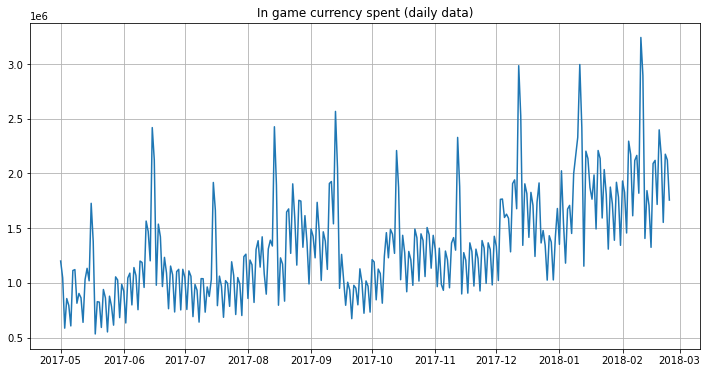

In [78]:
plt.figure(figsize=(12, 6))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In game currency spent (daily data)')
plt.grid(True)
plt.show()

In [79]:
# creating copy of initial datagrame to make various transformations
data = pd.DataFrame(ads.Ads.copy())
data.columns = ['y']

In [80]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data[f'lag_{i}'] = data.y.shift(i)

In [81]:
# take a look at the new dataframe
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds
tscv = TimeSeriesSplit(n_splits=5)

In [83]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to the timeseries sctructure
    """
    
    # get the index after which test set stats
    test_index = int(len(X)*(1 - test_size))
    
    X_train = X.iloc[:test_index -1]
    y_train = y.iloc[:test_index -1]
    X_test = X.iloc[:test_index]
    y_test = y.iloc[:test_index]
    
    return X_train, X_test, y_train, y_test

In [84]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=.3)

In [85]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [86]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

    
def plot_coefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ['coef']
    coefs['abs'] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');
def plot_coefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ['coef']
    coefs['abs'] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

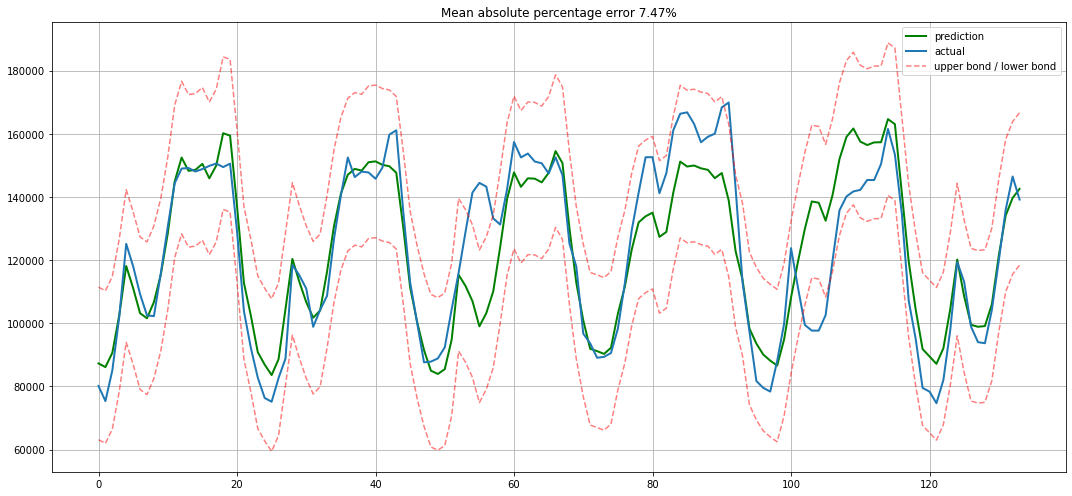

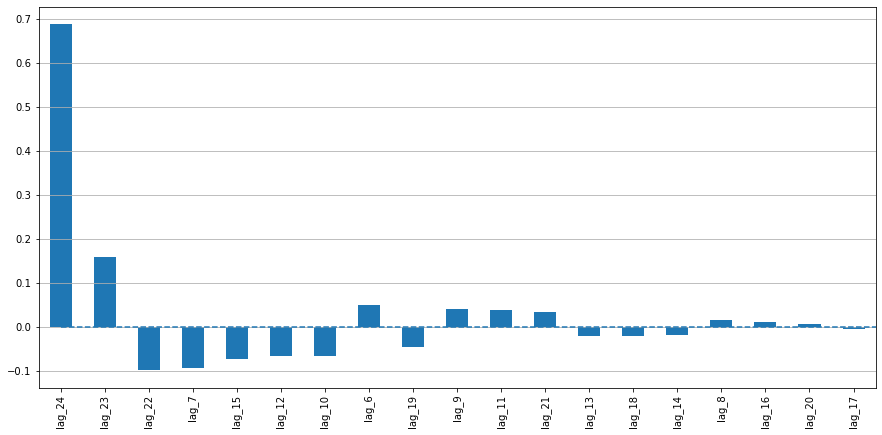

In [87]:
plotModelResults(lr, plot_intervals=True)
plot_coefficients(lr)

Добавим в датасет час, день недели и выходной в качестве категориальных переменных. Для этог переводим имеющийся в
датафрейме индекс в формат datetime и извлекаем из него hour и weekday.

In [88]:
data.index = pd.to_datetime(data.index)
data['hour'] = data.index.hour
data['weekday'] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5, 6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Можно визуализировать получившиеся признаки

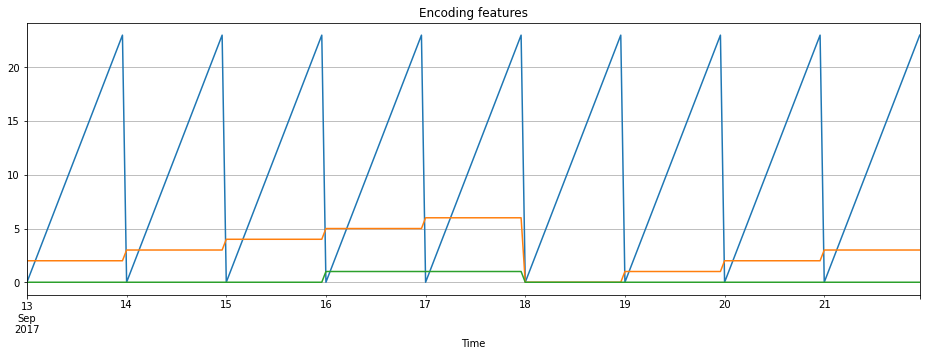

In [89]:
plt.figure(figsize=(16, 5))
plt.title('Encoding features')
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True)

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё
к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этоговоспользуемся *StandardScaler*

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

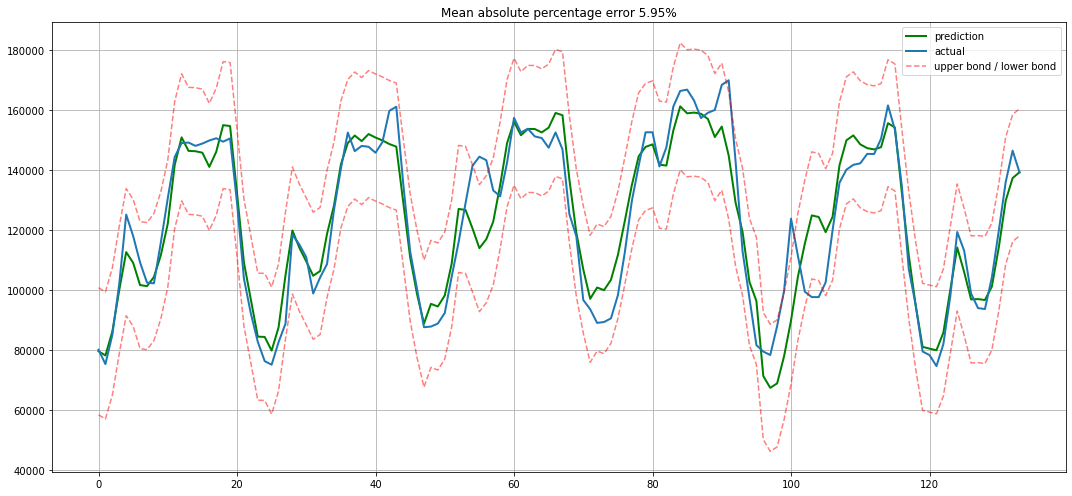

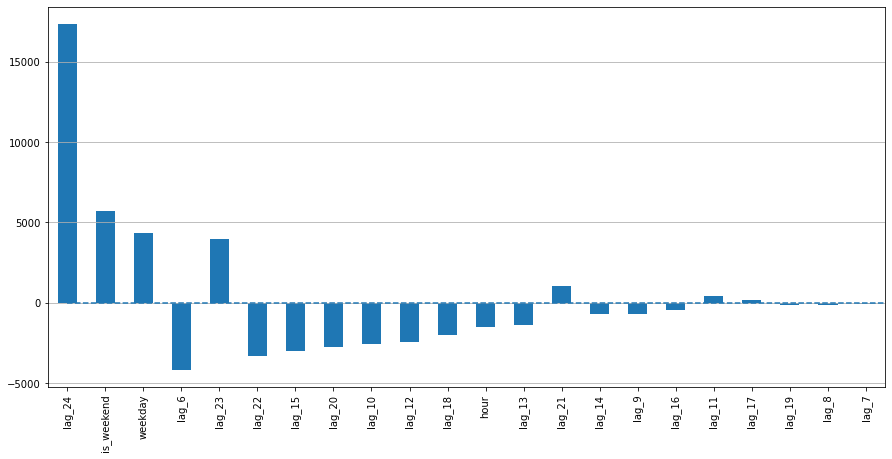

In [91]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plot_coefficients(lr)

Ошибка на тесте еще немного уменьшилась и по коэффициентам видно, что день недели выходной - довольн неплохие признаки

# Кодирование средним (target encoding)

Иногда в качестве признака добавлять среднее значение переменной. В нашем случае каждый день недели или час дня 
можно закодировать соответствующим средним числом просмотров рекламы/траты игровой валюты, пришедшиеся на этот день недели
или этот час. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тренировочного 
датасета (или в рамках текущего наблюдаемого фолда при кроссвалидации), иначе можно ненароком привнести в модель 
информацию о будущем.

In [92]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictonary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Посмотрим на средние по часам

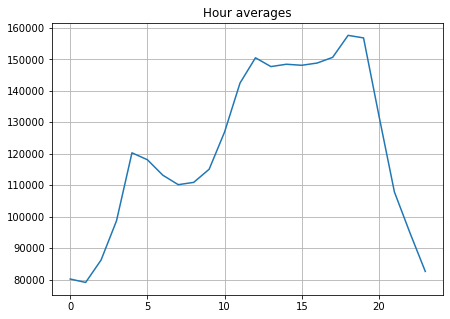

In [93]:
average_hour = code_mean(data, 'hour', 'y')
plt.figure(figsize=(7, 5))
plt.title('Hour averages')
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

А теперь объединим кодирование признаков одной функцией и добавим к признакам водирование средним

In [94]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False, get_dummies=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
            
        get_dummies: boolean
            if True - encode categorical into dummies
        
    """
        
    # copy of initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ['y']
    
    # lags of series
    for i in range(lag_start, lag_end):
        data[f'lag_{i}'] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5, 6]) * 1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna()) * (1 - test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', 'y').get, data.weekday))
        data['hour_average'] = list(map(code_mean(data[:test_index], 'hour', 'y').get, data.hour))
        
        # drop encoded variables
        data.drop(['hour', 'weekday'], axis=1, inplace=True)
        
    if get_dummies:
        data = pd.get_dummies(data, columns=['hour', 'weekday'])
        
    # train test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)
    
    return X_train, X_test, y_train, y_test

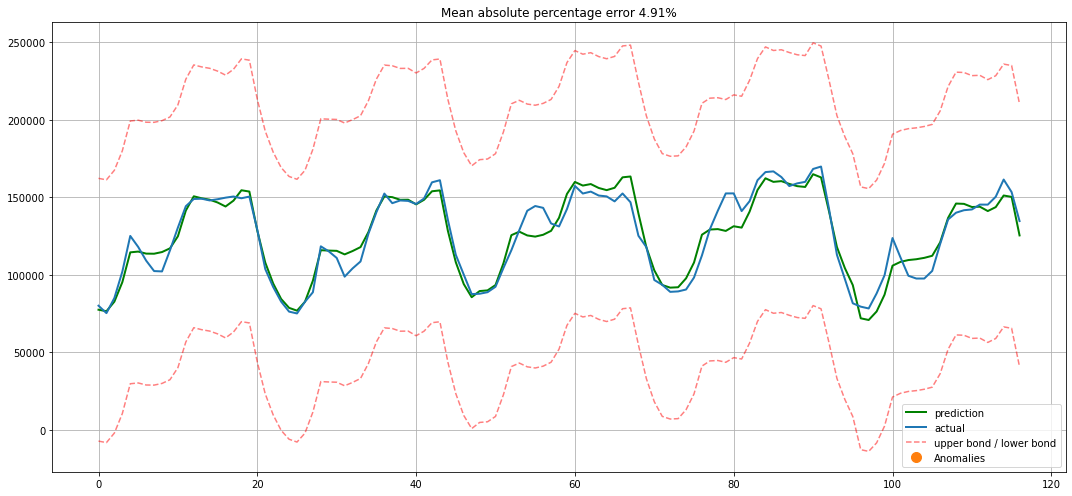

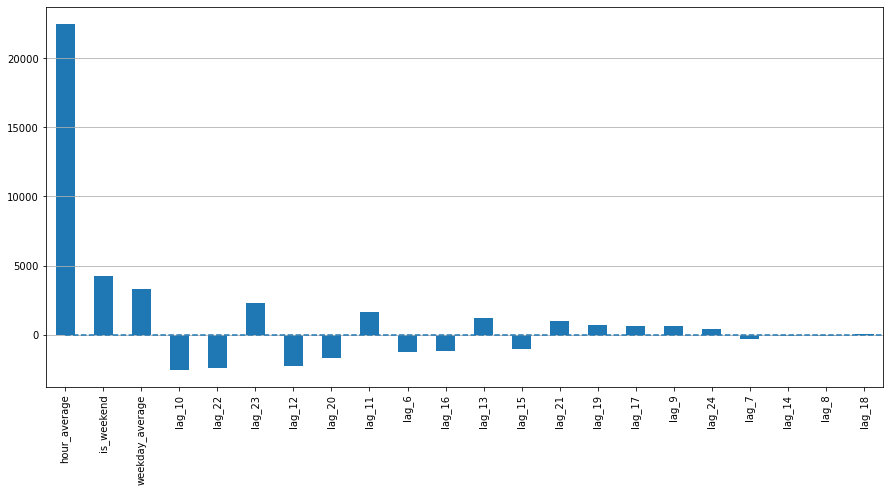

In [95]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plot_coefficients(lr)

In [96]:
X_train, X_test, y_train, y_test = prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=.3, target_encoding=False, get_dummies=True)

column_to_scale = [col for col in X_train.columns if 'lag' in col]
X_train_scaled = scaler.fit_transform(X_train[column_to_scale])
X_test_scaled = scaler.transform(X_test[column_to_scale])

X_train[column_to_scale] = X_train_scaled
X_test[column_to_scale] = X_test_scaled

In [97]:
X_train.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,1.462254,0.974267,0.751933,0.931678,0.889327,0.926818,1.160528,0.837541,0.166984,-0.392067,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 01:00:00,1.548454,1.447228,0.964154,0.741253,0.918151,0.875691,0.911138,1.151101,0.832507,0.161860,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 02:00:00,0.586940,1.533367,1.436354,0.952796,0.727666,0.904675,0.859628,0.899558,1.149545,0.830436,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 03:00:00,-0.623276,0.572521,1.522356,1.423488,0.939276,0.713126,0.888829,0.847603,0.895211,1.148930,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 04:00:00,-0.951339,-0.636854,0.563053,1.509215,1.410117,0.925918,0.695847,0.877057,0.842680,0.893429,...,0,0,0,0,0,0,1,0,0,0


Для начала убедимся, что нам есть, что отбрасывать и в данных действительно очень моного скореллированных признаков

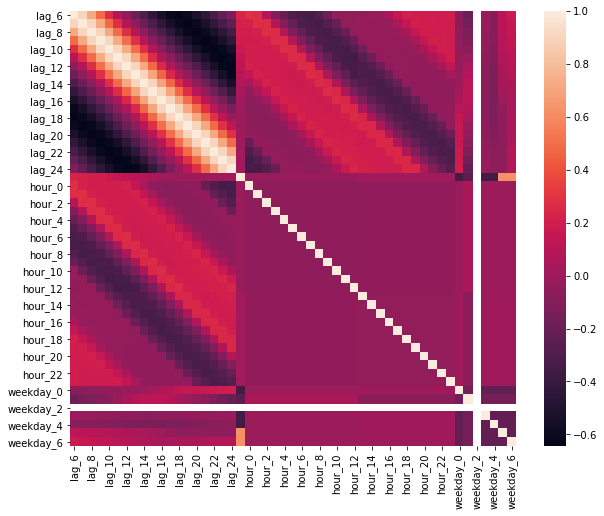

In [98]:
plt.figure(figsize=(10, 8))
sns.heatmap(X_train.corr());

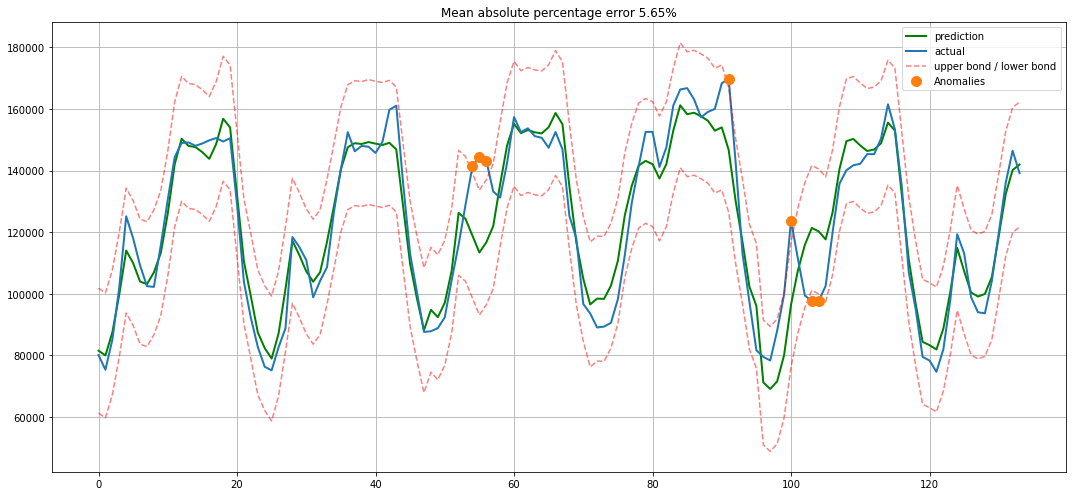

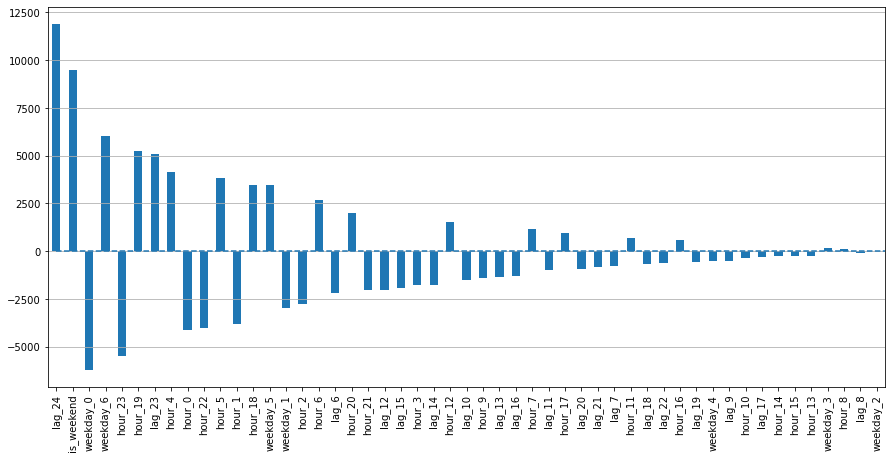

In [99]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True, plot_anomalies=True)
plot_coefficients(ridge)

Хорошо видно, как всё ближе и ближе прижимаются к нулю (хотя никогда нулю не равны) коэффициенты в моделе по мере убывания их важности.

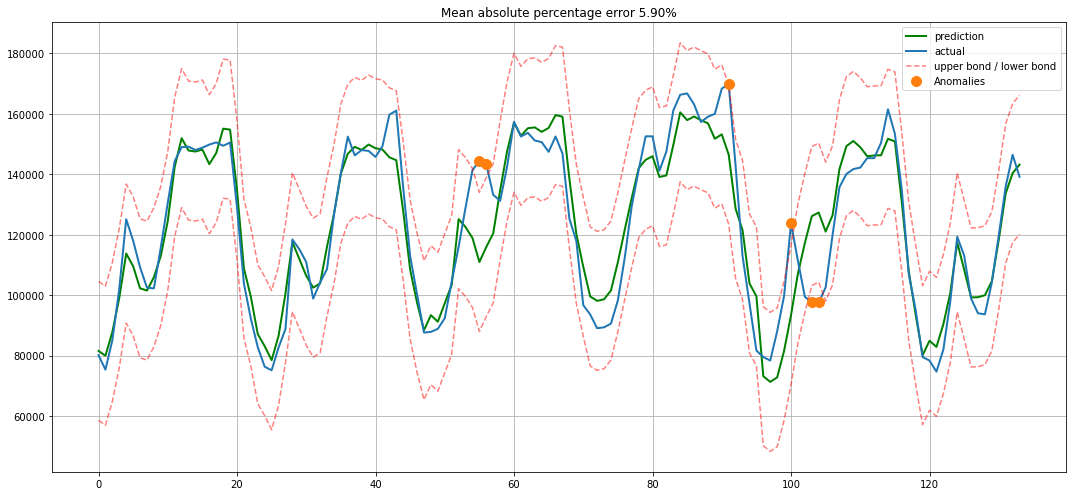

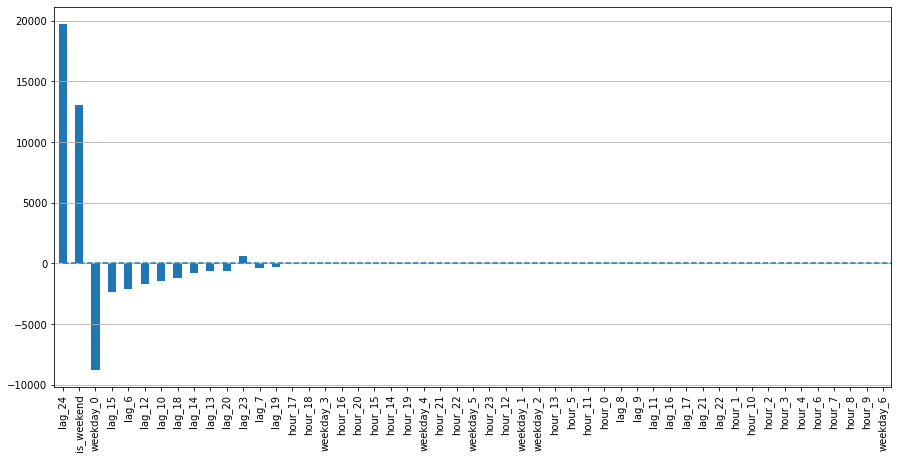

In [100]:
lasso = LassoCV(cv=tscv, eps=.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso,
                 X_train=X_train,
                 X_test=X_test,
                 plot_intervals=True, plot_anomalies=True)
plot_coefficients(lasso)

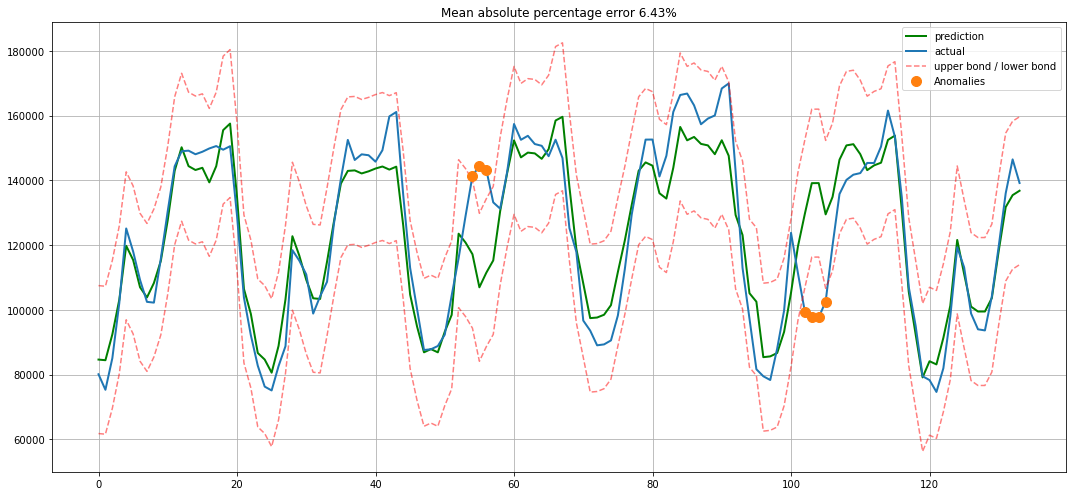

In [101]:
lasso = LassoCV(cv=tscv, eps=.01)
lasso.fit(X_train[['lag_24', 'is_weekend', 'weekday_0']], y_train)

plotModelResults(lasso,
                 X_train=X_train[['lag_24', 'is_weekend', 'weekday_0']],
                 X_test=X_test[['lag_24', 'is_weekend', 'weekday_0']],
                 plot_intervals=True, plot_anomalies=True)
# plot_coefficients(lasso)

# Boosting

Почему бы теперь не попробовать бустинг?

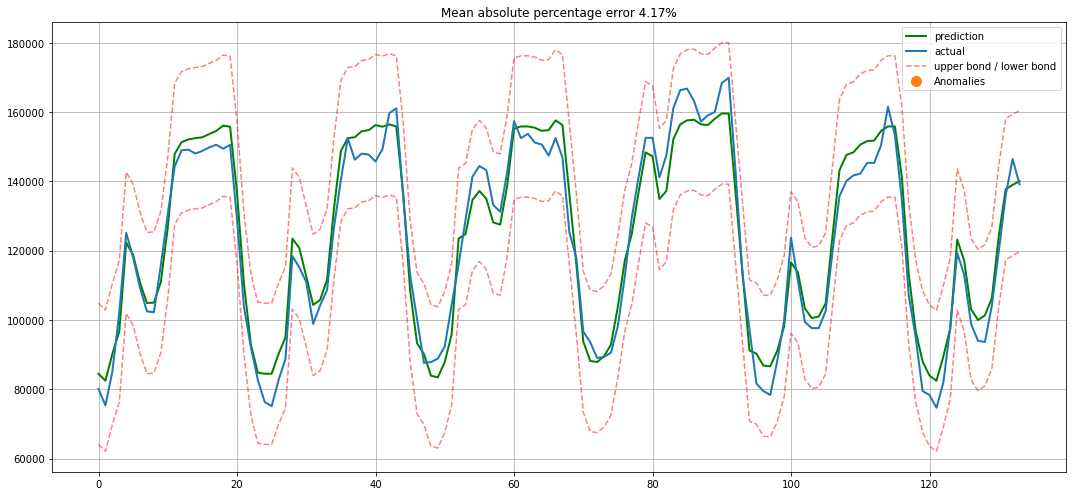

In [102]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr,
                  X_train=X_train_scaled,
                  X_test=X_test_scaled,
                  plot_intervals=True, plot_anomalies=True)

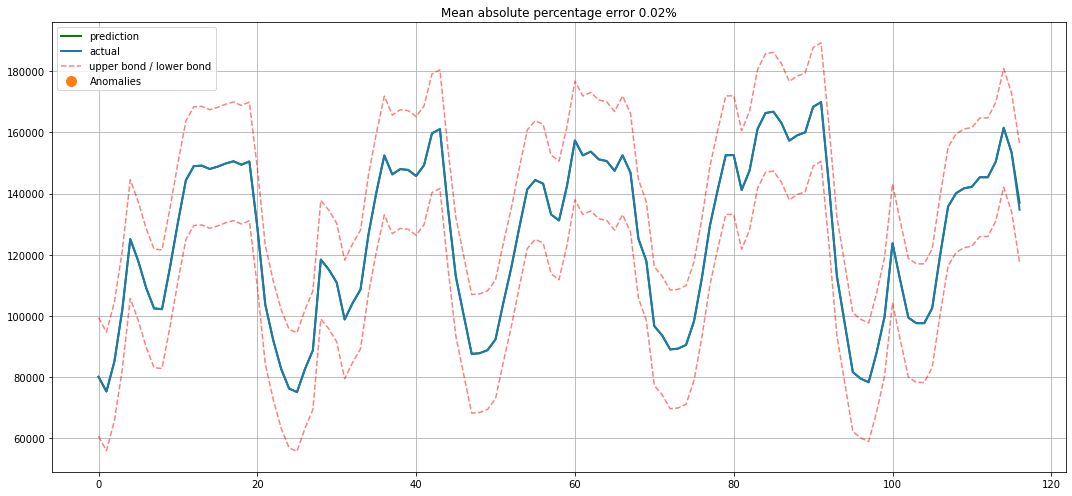

In [103]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test = \
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

catboost = CatBoostRegressor(iterations=100, learning_rate=.7,
                            loss_function='RMSE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost,
                X_train=X_train_scaled,
                X_test=X_test_scaled,
                plot_intervals=True, plot_anomalies=True)

Не стоит первым делом при работе с временным рядом расчехлять xgboost. Дело в том, что модели с деревьями внутри,
в отличие от линейных, довольно плохо справляются с трендами без помощи трюков с обработкой данных. 
В идеале - предварительно очистить данные от тренда, спрогнозировать тренд отдельно при помощи линейной модели, и
отдельно очищенный ряд, а потом сложить вместе предсказания.

# To Infinity and Beyond

## Facebook Prophet - automatic routines

## Facebook Prophet - automating routines

![](https://miro.medium.com/max/1060/0*tVCene42rgUTNv9Q.png)

https://github.com/facebook/prophet

[Предсказываем будущее с помощью библиотеки Facebook Prophet](https://habrahabr.ru/company/ods/blog/323730/)

Библиотека prophet позволяет быстро и достаточно качественно автоматически строить прогнозы временныз рядов. Подробно про теорию работы можно почитать в замечательной статьей по ссылке выше, а сейчас посмотрим на практике, как она работает

In [104]:
from fbprophet import Prophet

In [105]:
# number of future predictions
predictions = 60

# creating a specific format dataset 
df = ads.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
211,2017-09-21 19:00:00,155890
212,2017-09-21 20:00:00,123395
213,2017-09-21 21:00:00,103080
214,2017-09-21 22:00:00,95155
215,2017-09-21 23:00:00,80285


In [106]:
# reserve some data for testing
train_df = df[:-predictions]

In [107]:
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()

,ds
211,2017-09-21 19:00:00
212,2017-09-21 20:00:00
213,2017-09-21 21:00:00
214,2017-09-21 22:00:00
215,2017-09-21 23:00:00


In [108]:
# finally, making predictions
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
211,2017-09-21 19:00:00,127074.735675,139827.460307,161767.127267,127074.729927,127074.740911,24056.552575,24056.552575,24056.552575,27773.244502,27773.244502,27773.244502,-3716.691927,-3716.691927,-3716.691927,0.0,0.0,0.0,151131.288250
212,2017-09-21 20:00:00,127102.530827,124466.683088,145222.906279,127102.524875,127102.536264,7760.561676,7760.561676,7760.561676,11520.897510,11520.897510,11520.897510,-3760.335833,-3760.335833,-3760.335833,0.0,0.0,0.0,134863.092503
213,2017-09-21 21:00:00,127130.325979,103090.293886,124887.780959,127130.319917,127130.331582,-12937.152732,-12937.152732,-12937.152732,-9160.021702,-9160.021702,-9160.021702,-3777.131030,-3777.131030,-3777.131030,0.0,0.0,0.0,114193.173247
214,2017-09-21 22:00:00,127158.121131,85287.684083,106294.940886,127158.114897,127158.126857,-31596.300985,-31596.300985,-31596.300985,-27829.044713,-27829.044713,-27829.044713,-3767.256273,-3767.256273,-3767.256273,0.0,0.0,0.0,95561.820146
215,2017-09-21 23:00:00,127185.916283,72619.975264,93850.083470,127185.909864,127185.922184,-43851.662332,-43851.662332,-43851.662332,-40120.592087,-40120.592087,-40120.592087,-3731.070245,-3731.070245,-3731.070245,0.0,0.0,0.0,83334.253951


In [109]:
# pictures!
error = mean_absolute_percentage_error

Mean absolute percentage error 8.67%


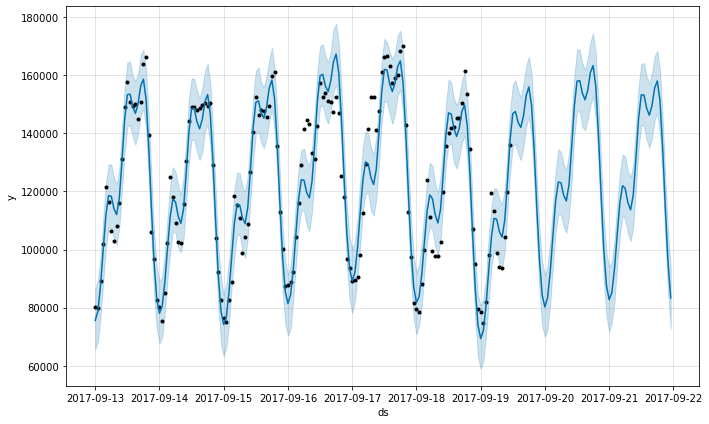

In [110]:
# pictures!
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error))
_ = model.plot(forecast)

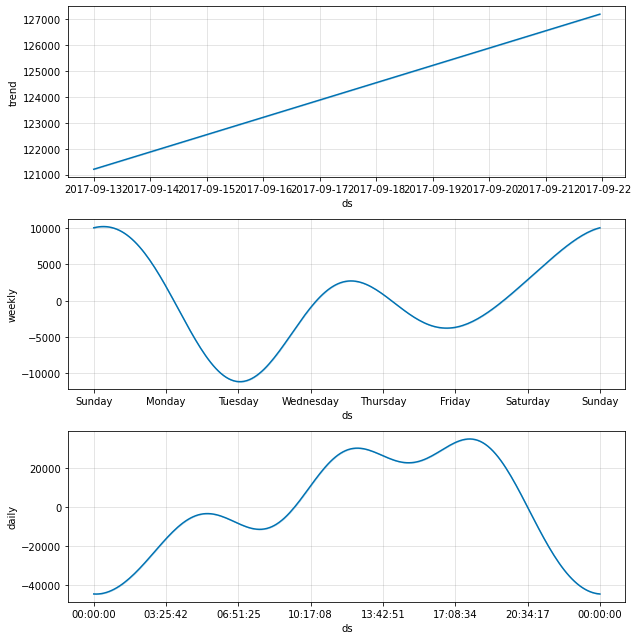

In [113]:
_ = model.plot_components(forecast)

# Amazon GluonTS - new big player on the market 

https://github.com/awslabs/gluon-ts

В июне 2019 года компания Amazon выложила в открытый доступ замечательный инструмент - [GluonTS](https://github.com/awslabs/gluon-ts), позволяющий максимально быстро и эффективно строить, оценивать и использовать модели временных рядов, основанные на глубоком обучении и вероятностном подходе. 

## Что внутри GluonTS?

Amazon пошёл дальше и использовал рекуррентные нейронные сети (в частности, LSTM), а также свертки и механизмы внимания, обернув всё это в крайне удобную верхнеуровневую библиотеку. В частности, GluonTS содержит:
- Инструменты, необходимые для построения и обучения наиболее распространённых архитектур нейронных сетей, а также компоненты для моделирования и трансформации вероятностых распределений
- Механизмы для загрузки и предварительной обработки данных, в том числе автоматической генерации признаков из временных рядов
- Несколько готовых к использованию state-of-the-art прогнозных моделей
- Инструменты для оценки и сравнения различных моделей

Если не вдаваться в подробности, GluonTS позволяет быстро и практически из коробки получить качественную модель временного ряда, на выходе из которой вместо точечной оценки прогнозных значений мы получаем целое смоделированное вероятностное распределение. Таким образом, мы можем с лёгкостью оперировать доверительными интервалами прогноза и с любой удобной нам вероятностью получать диапазон наиболее вероятных будущих значений ряда. 


В [оригинальной статье](https://aws.amazon.com/ru/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/) авторы использовали временной ряд с ценами акций компании Amazon. Ярко выраженных паттернов, за исключением восходящих/нисходящих трендов, в финансовых временных рядах обычно не бывает, поэтому прогнозы в статье выглядят больше как некоторый шум, колеблющийся вокруг спрогнозированной линии тренда.

Так что посмотрим, чего можно добиться на наших собственных данных

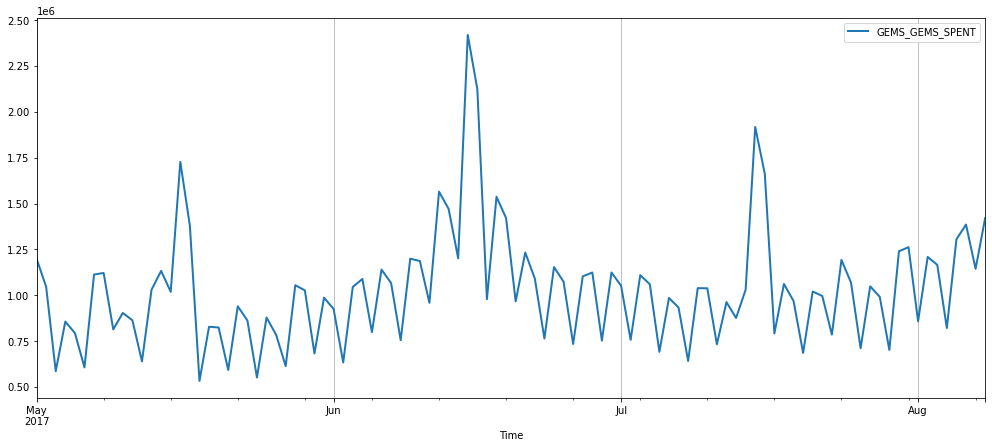

In [111]:
df = pd.read_csv('datasets/currency.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df[:100].plot(linewidth=2, figsize=(17, 7))
plt.grid(axis='x')
plt.show()

## Готовим данные

Пробуем построить модель. GluonTS представляет верхнеуровневую абстракцию *Dataset*, которая переводит разнородные форматы
данных в один, удобный для последующей работы моделей. В часности, *ListDataset* переводит данные в списов словарей, где
отдельно записаны значения ряда и таймстампы. Для создания такого датасета мы передаем наш исходный временной ряд, указываем
его частоту (в данном случае у нас дневные данные, поэтому частота "D"), а так же точку, до которой наш ряд будет отнесен
к тренировочной выборке.

In [114]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{'start': df.index[0], 'target': df.GEMS_GEMS_SPENT[:'2017-08-01']}],
    freq = 'D'
)

Посмотрим, в какой формат преобразовались данные

In [115]:
training_data.list_data

[{'start': Timestamp('2017-05-01 00:00:00'),
  'target': Time
  2017-05-01    1199436
  2017-05-02    1045515
  2017-05-03     586111
  2017-05-04     856601
  2017-05-05     793775
                 ...   
  2017-07-28     991163
  2017-07-29     701672
  2017-07-30    1239717
  2017-07-31    1261953
  2017-08-01     857930
  Name: GEMS_GEMS_SPENT, Length: 93, dtype: int64}]